# Biharmonic Equation in 2D Cartesian Coordinates (2 inlets and 1 outlet)

**Settings**

The Biharmonic function in 2d cartesian coordinates is:
\begin{equation}
\nabla^4 \phi = \nabla^2 (\nabla^2 \phi) = \frac{\partial^4 \phi}{\partial x^4} + 2 \frac{\partial^4 \phi}{\partial x^2 \partial y^2} + \frac{\partial^4 \phi}{\partial y^4} = 0
\end{equation}

With the boundary conditions:

\begin{equation}
\frac{\partial \phi}{\partial x} = \frac{\partial \phi}{\partial y} = 0, \quad & \text{when } y = 0 \text{ and } y = 1  \\
\frac{\partial \phi}{\partial x} = 0, \frac{\partial \phi}{\partial y} = f(y), \quad & \text{when } x = 0 \\
\frac{\partial \phi}{\partial x} = 0, \frac{\partial \phi}{\partial y} = g(y), \quad & \text{when } x = 1 
\end{equation}

where assume 
\begin{equation}
f(y) = 
\begin{cases}
C_1 * ((\lambda /4)^2 - (y-1/3)^2) \qquad & 1/3 - \lambda/4 < y < 1/3 + \lambda/4\\
C_1 * ((\lambda /4)^2 - (y-2/3)^2) \qquad & 2/3 - \lambda/4 < y < 2/3 + \lambda/4\\
0 \qquad &  \text{elsewhere}
\end{cases}
\end{equation}

and

\begin{equation}
g(y) = 
\begin{cases}
C_2 * ((\lambda /2)^2 - (y-1/2)^2) \qquad & 1/2 - \lambda/2 < y < 1/2 + \lambda/2\\
0 \qquad &  \text{elsewhere}
\end{cases}
 
\end{equation}

### Central Difference Discretization

In [48]:
import numpy as np
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

In [98]:
# Define the grid
Nx, Ny = 108, 108  # number of grid points in x and y direction
x = np.linspace(0, 1, Nx+1)
y = np.linspace(0, 1, Ny+1)
dx, dy = x[1] - x[0], y[1] - y[0]

# Count the number of rows in the matrix A
count_row = 0


In [50]:
# Initialize the discretisation matrix and right-hand side vector
A = np.zeros(((Nx+1) * (Ny+1), (Nx+1) * (Ny+1))) 
b = np.zeros((Nx+1) * (Ny+1)) # the right-hand side vector, len(b) = the number of rows in A
# U = [U00, U10 ... UN0, U10, U01, U11 ... UN1 ... U0N, U1N ... UNN] with length (N+1)^2


In [52]:
# Two inlets and one outlet
# Define function f(y) and g(y)
def f(z, C = 40, lamb = 2/10):
    # Step function
    if 1/3 - lamb/4 < z <= 1/3:
        return C * (lamb/4 - (1/3-z))
    elif 1/3 < z < 1/3 + lamb/4:
        return C * (lamb/4 - (z-1/3))
    elif 2/3 - lamb/4 < z <= 2/3:
        return C * (lamb/4 - (2/3-z))
    elif 2/3 < z < 2/3 + lamb/4:
        return C * (lamb/4 - (z-2/3))
    else:
        return 0

def g(z, C = 20, lamb = 2/10):
    # Step function
    if 1/2 - lamb/2 < z <= 1/2:
        return C * (lamb/2 - (1/2-z))
    elif 1/2 < z < 1/2 + lamb/2:
        return C * (lamb/2 - (z-1/2))
    else:
        return 0

In [53]:
# # Two inlets and one outlet
# # Define function f(y) and g(y)
# def f(z, C = 120, lamb = 2/10):
#     # Step function
#     if 1/3 - lamb/4 < z < 1/3 + lamb/4:
#         return C * ((lamb/4)**2 - (z-1/3)**2)
#     elif 2/3 - lamb/4 < z < 2/3 + lamb/4:
#         return C * ((lamb/4)**2 - (z-2/3)**2)
#     else:
#         return 0
# 
# def g(z, C = 30, lamb = 2/10):
#     if 1/2 - lamb/2 < z < 1/2 + lamb/2:
#         return C * ((lamb/2)**2 - (z-1/2)**2)
#     else:
#         return 0

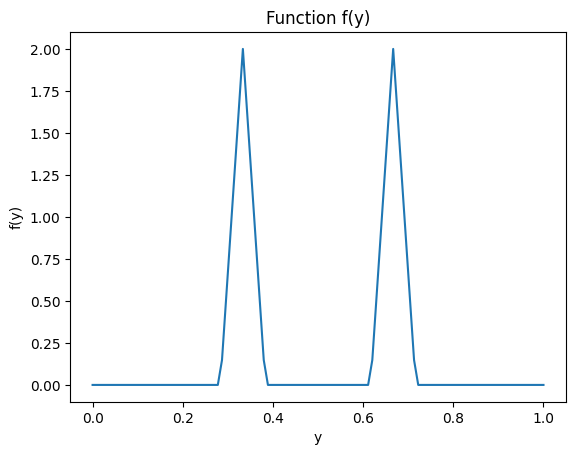

In [95]:
# # Plot function f
# import matplotlib.pyplot as plt
# x = np.linspace(0, 1, Nx+1)
# y = [f(i) for i in x]
# plt.plot(x, y)
# plt.title('Function f(y)')
# plt.xlabel('y')
# plt.ylabel('f(y)')
# plt.show()


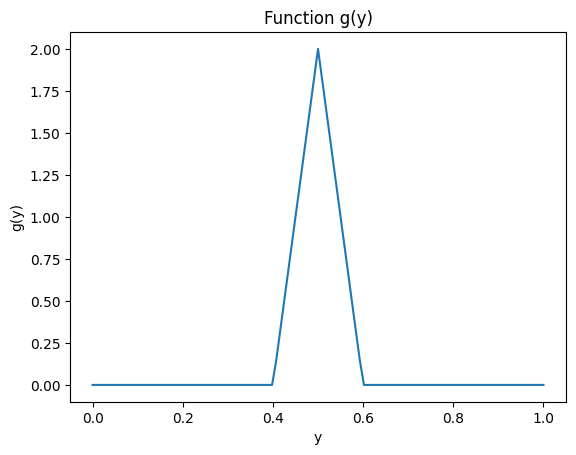

In [96]:
# # Plot function g
# x = np.linspace(0, 1, Nx+1)
# y = [g(i) for i in x]
# plt.plot(x, y)
# plt.title('Function g(y)')
# plt.xlabel('y')
# plt.ylabel('g(y)')
# plt.show()

In [56]:
# inertia points: thirteen points 
# for i in range(2, Nx - 1):  # Start from 2 and end at Nx-2 to avoid out-of-bounds
# for j in range(2, Ny - 1):  # Start from 2 and end at Ny-2 for the same reason
# Ui-2,j - 8Ui-1,j + 20Ui,j - 8Ui+1,j + Ui+2,j + Ui,j-2 - 8Ui,j-1 - 8Ui,j+1 + Ui,j+2 + 2Ui-1,j-1 + 2Ui-1,j+1 + 2Ui+1,j-1 + 2Ui+1,j+1 = 0
# rearranging the equation in the same order as the U vector
# Ui,j-2 + 2Ui-1,j-1 - 8Ui,j-1 + 2Ui+1,j-1 + Ui-2,j - 8Ui-1,j + 20Ui,j - 8Ui+1,j + Ui+2,j + 2Ui-1,j+1 - 8Ui,j+1 + 2Ui+1,j+1 + Ui,j+2 = 0

# boundary points
# if j == 0 or j == Ny: 
# for i in range(1, Nx):  # Start from 1 and end at Nx-1 to avoid out-of-bounds
# leapfrog finite difference approximation for the first derivative in BC
# dphi/dx = 0 => (- Ui-1,j + Ui+1,j) / (2*dx) = 0
# (- Ui-1,0 + Ui+1,0) / (2*dx) = 0
# (- Ui-1,Ny + Ui+1,Ny) / (2*dx) = 0

# if i == 0 or i == Nx:
# leapfrog finite difference approximation for the first derivative in BC
# for j in range(1, Ny):  # Start from 1 and end at Ny-1 to avoid out-of-bounds
# dphi/dy = f(y) or g(y) => (Ui,j+1 - Ui,j-1) / (2*dy) = f(j*dy) or g(j*dy)
# (- U0,j-1 + U0,j+1)/ (2*dy) = f(j*dy)
# (- UNx,j-1 + UNx,j+1)/ (2*dy) = g(j*dy)

# four corner points
# second-order forward/backward finite difference approximation for the first derivative
# if i == 0 and j == 0:
# -3/2 U0,0 +2 U1,0 -1/2 U2,0 = 0

# if i == 0 and j == Ny:
# -3/2 U0,Ny +2 U1,Ny -1/2 U2,Ny = 0

# if i == Nx and j == 0:
# 1/2 UNx-2,0 -2 UNx-1,0 +3/2 UNx,0 = 0

# if i == Nx and j == Ny:
# 1/2 UNx-2,Ny -2 UNx-1,Ny +3/2 UNx,Ny = 0

# i, j = 1 or Nx-1 square points
# if j == 1 and i in range(2, Nx-1): avoid the corner points
# from bc we have: Ui,-1 = Ui,1
# Ui,-1 + 2Ui-1,0 - 8Ui,0 + 2Ui+1,0 + Ui-2,1 - 8Ui-1,1 + 20Ui,1 - 8Ui+1,1 + Ui+2,1 + 2Ui-1,2 - 8Ui,2 + 2Ui+1,2 + Ui,3 = 0
# so:
# 2Ui-1,0 - 8Ui,0 + 2Ui+1,0 + Ui-2,1 - 8Ui-1,1 + 21Ui,1 - 8Ui+1,1 + Ui+2,1 + 2Ui-1,2 - 8Ui,2 + 2Ui+1,2 + Ui,3 = 0

# if j == Ny-1 and i in range(2, Nx-1): avoid the corner points
# from bc we have: Ui,Ny+1 = Ui,Ny-1
# Ui,Ny-3 + 2Ui-1,Ny-2 - 8Ui,Ny-2 + 2Ui+1,Ny-2 + Ui-2,Ny-1 - 8Ui-1,Ny-1 + 20Ui,Ny-1 - 8Ui+1,Ny-1 + Ui+2,Ny-1 + 2Ui-1,Ny - 8Ui,Ny + 2Ui+1,Ny + Ui,Ny+1 = 0
# so:
# Ui,Ny-3 + 2Ui-1,Ny-2 - 8Ui,Ny-2 + 2Ui+1,Ny-2 + Ui-2,Ny-1 - 8Ui-1,Ny-1 + 21Ui,Ny-1 - 8Ui+1,Ny-1 + Ui+2,Ny-1 + 2Ui-1,Ny - 8Ui,Ny + 2Ui+1,Ny = 0

# if i == 1 and j in range(2, Ny-1): avoid the corner points
# from bc we have: U-1,j = U1,j
# U1,j-2 + 2U0,j-1 - 8U1,j-1 + 2U2,j-1 + U-1,j - 8U0,j + 20U1,j - 8U2,j + U3,j + 2U0,j+1 - 8U1,j+1 + 2U2,j+1 + U1,j+2 = 0
# so:
# U1,j-2 + 2U0,j-1 - 8U1,j-1 + 2U2,j-1 - 8U0,j + 21U1,j - 8U2,j + U3,j + 2U0,j+1 - 8U1,j+1 + 2U2,j+1 + U1,j+2 = 0

# if i == Nx-1 and j in range(2, Ny-1): avoid the corner points
# from bc we have: UNx+1,j = UNx-1,j
# UNx-1,j-2 + 2UNx-2,j-1 - 8UNx-1,j-1 + 2UNx,j-1 + UNx-3,j - 8UNx-2,j + 20UNx-1,j - 8UNx,j + UNx+1,j + 2UNx-2,j+1 - 8UNx-1,j+1 + 2UNx,j+1 + UNx-1,j+2 = 0
# so:
# UNx-1,j-2 + 2UNx-2,j-1 - 8UNx-1,j-1 + 2UNx,j-1 + UNx-3,j - 8UNx-2,j + 21UNx-1,j - 8UNx,j + 2UNx-2,j+1 - 8UNx-1,j+1 + 2UNx,j+1 + UNx-1,j+2 = 0

# four corner points
# if i == 1 and j == 1:
# from bc we have: U1,-1 = U1,1 = U-1,1 
# U1,-1 + 2U0,0 - 8U1,0 + 2U2,0 + U-1,1 - 8U0,1 + 20U1,1 - 8U2,1 + U3,1 + 2U0,2 - 8U1,2 + 2U2,2 + U1,3 = 0
# so:
# 2U0,0 - 8U1,0 + 2U2,0 - 8U0,1 + 22U1,1 - 8U2,1 + U3,1 + 2U0,2 - 8U1,2 + 2U2,2 + U1,3 = 0

# if i == 1 and j == Ny-1:
# from bc we have: U1,Ny+1 = U1,Ny-1 = U-1,Ny-1
# U1,Ny-3 + 2U0,Ny-2 - 8U1,Ny-2 + 2U2,Ny-2 + U-1,Ny-1 - 8U0,Ny-1 + 20U1,Ny-1 - 8U2,Ny-1 + U3,Ny-1 + 2U0,Ny - 8U1,Ny + 2U2,Ny + U1,Ny+1 = 0
# so:
# U1,Ny-3 + 2U0,Ny-2 - 8U1,Ny-2 + 2U2,Ny-2 - 8U0,Ny-1 + 22U1,Ny-1 - 8U2,Ny-1 + U3,Ny-1 + 2U0,Ny - 8U1,Ny + 2U2,Ny = 0

# if i == Nx-1 and j == 1:
# from bc we have: UNx+1,1 = UNx-1,1 = UNx-1,-1
# UNx-1,-1 + 2UNx-2,0 - 8UNx-1,0 + 2UNx,0 + UNx-3,1 - 8UNx-2,1 + 20UNx-1,1 - 8UNx,1 + UNx+1,1 + 2UNx-2,2 - 8UNx-1,2 + 2UNx,2 + UNx-1,3 = 0
# so:
# 2UNx-2,0 - 8UNx-1,0 + 2UNx,0 + UNx-3,1 - 8UNx-2,1 + 22UNx-1,1 - 8UNx,1 + 2UNx-2,2 - 8UNx-1,2 + 2UNx,2 + UNx-1,3 = 0

# if i == Nx-1 and j == Ny-1:
# from bc we have: UNx+1,Ny-1 = UNx-1,Ny-1 = UNx-1,Ny+1
# UNx-1,Ny-3 + 2UNx-2,Ny-2 - 8UNx-1,Ny-2 + 2UNx,Ny-2 + UNx-3,Ny-1 - 8UNx-2,Ny-1 + 22UNx-1,Ny-1 - 8UNx,Ny-1 + 2UNx-2,Ny - 8UNx-1,Ny + 2UNx,Ny = 0


In [57]:
# Function to map 2D grid coordinates to 1D vector index
def idx(i, j):
    return i + j * (Ny+1)


In [58]:
# Fill the matrix A and vector b for the internal points
for i in range(2, Nx - 1):  # Start from 2 and end at Nx-2 to avoid out-of-bounds
    for j in range(2, Ny - 1):  # Start from 2 and end at Ny-2 for the same reason
        index = idx(i, j)
        # Ui,j-2 + 2Ui-1,j-1 - 8Ui,j-1 + 2Ui+1,j-1 + Ui-2,j - 8Ui-1,j + 20Ui,j - 8Ui+1,j + Ui+2,j + 2Ui-1,j+1 - 8Ui,j+1 + 2Ui+1,j+1 + Ui,j+2 = 0
        A[count_row, idx(i, j-2)] = 1
        A[count_row, idx(i-1, j-1)] = 2
        A[count_row, idx(i, j-1)] = -8
        A[count_row, idx(i+1, j-1)] = 2
        A[count_row, idx(i-2, j)] = 1
        A[count_row, idx(i-1, j)] = -8
        A[count_row, idx(i, j)] = 20
        A[count_row, idx(i+1, j)] = -8
        A[count_row, idx(i+2, j)] = 1
        A[count_row, idx(i-1, j+1)] = 2
        A[count_row, idx(i, j+1)] = -8
        A[count_row, idx(i+1, j+1)] = 2
        A[count_row, idx(i, j+2)] = 1
            
        b[count_row] = 0
        count_row += 1
    
print(f'count_row: {count_row}')

count_row: 11025


In [59]:
# boundary points
# y = 0:
# (- Ui-1,0 + Ui+1,0) / (2*dx) = 0
for i in range(1, Nx):
    A[count_row, idx(i-1, 0)] = -1
    A[count_row, idx(i+1, 0)] = 1
        
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 11132


In [60]:
# boundary points
# y = 1:
# (- Ui-1,Ny + Ui+1,Ny) / (2*dx) = 0
for i in range(1, Nx):
    A[count_row, idx(i-1, Ny)] = -1
    A[count_row, idx(i+1, Ny)] = 1
        
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 11239


In [61]:
# boundary points
# x = 0: 
# (- U0,j-1 + U0,j+1)/ (2*dy) = f(j*dy)
for j in range(1, Ny):
    A[count_row, idx(0, j-1)] = -1/(2*dy)
    A[count_row, idx(0, j+1)] = 1/(2*dy)
        
    b[count_row] = f(j*dy)
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 11346


In [62]:
# boundary points
# x = 1: 
# (- UNx,j-1 + UNx,j+1)/ (2*dy) = g(j*dy)
for j in range(1, Ny):
    A[count_row, idx(Nx, j-1)] = -1/(2*dy)
    A[count_row, idx(Nx, j+1)] = 1/(2*dy)
        
    b[count_row] = g(j*dy)
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 11453


In [63]:
# four corner points
# Take the laplacian of the corner points
# d^2Phi/dx^2 + d^2Phi/dy^2 = 0
# if i == 0 and j == 0:
# -4 U0,0 +2 U1,0 +2 U0,1 = 0
A[count_row, idx(0, 0)] = -4
A[count_row, idx(1, 0)] = 2
A[count_row, idx(0, 1)] = 2
b[count_row] = 0
count_row += 1

# if i == 0 and j == Ny:
# -4 U0,Ny +2 U1,Ny +2 U0,Ny-1 = 0
A[count_row, idx(0, Ny)] = -4
A[count_row, idx(1, Ny)] = 2
A[count_row, idx(0, Ny-1)] = 2
b[count_row] = 0
count_row += 1

# if i == Nx and j == 0:
# 2 UNx,1 +2 UNx-1,0 -4 UNx,0 = 0
A[count_row, idx(Nx, 1)] = 2
A[count_row, idx(Nx-1, 0)] = 2
A[count_row, idx(Nx, 0)] = -4
b[count_row] = 0
count_row += 1

# if i == Nx and j == Ny:
# 2 UNx,Ny-1 +2 UNx-1,Ny -4 UNx,Ny = 0
A[count_row, idx(Nx, Ny-1)] = 2
A[count_row, idx(Nx-1, Ny)] = 2
A[count_row, idx(Nx, Ny)] = -4
b[count_row] = 0
count_row += 1

print(f'count_row: {count_row}')

count_row: 11457


In [64]:
# # four corner points
# # if i == 0 and j == 0:
# # -3/2 U0,0 +2 U1,0 -1/2 U2,0 = 0
# A[count_row, idx(0, 0)] = -3/2
# A[count_row, idx(1, 0)] = 2
# A[count_row, idx(2, 0)] = -1/2
# b[count_row] = 0
# count_row += 1
# 
# # if i == 0 and j == Ny:
# # -3/2 U0,Ny +2 U1,Ny -1/2 U2,Ny = 0
# A[count_row, idx(0, Ny)] = -3/2
# A[count_row, idx(1, Ny)] = 2
# A[count_row, idx(2, Ny)] = -1/2
# b[count_row] = 0
# count_row += 1
# 
# # if i == Nx and j == 0:
# # 1/2 UNx-2,0 -2 UNx-1,0 +3/2 UNx,0 = 0
# A[count_row, idx(Nx-2, 0)] = 1/2
# A[count_row, idx(Nx-1, 0)] = -2
# A[count_row, idx(Nx, 0)] = 3/2
# b[count_row] = 0
# count_row += 1
# 
# # if i == Nx and j == Ny:
# # 1/2 UNx-2,Ny -2 UNx-1,Ny +3/2 UNx,Ny = 0
# A[count_row, idx(Nx-2, Ny)] = 1/2
# A[count_row, idx(Nx-1, Ny)] = -2
# A[count_row, idx(Nx, Ny)] = 3/2
# b[count_row] = 0
# count_row += 1
# 
# print(f'count_row: {count_row}')

In [65]:
# if j == 1 and i in range(2, Nx-1):
# 2Ui-1,0 - 8Ui,0 + 2Ui+1,0 + Ui-2,1 - 8Ui-1,1 + 21Ui,1 - 8Ui+1,1 + Ui+2,1 + 2Ui-1,2 - 8Ui,2 + 2Ui+1,2 + Ui,3 = 0
for i in range(2, Nx-1):
    A[count_row, idx(i-1, 0)] = 2
    A[count_row, idx(i, 0)] = -8
    A[count_row, idx(i+1, 0)] = 2
    A[count_row, idx(i-2, 1)] = 1
    A[count_row, idx(i-1, 1)] = -8
    A[count_row, idx(i, 1)] = 21
    A[count_row, idx(i+1, 1)] = -8
    A[count_row, idx(i+2, 1)] = 1
    A[count_row, idx(i-1, 2)] = 2
    A[count_row, idx(i, 2)] = -8
    A[count_row, idx(i+1, 2)] = 2
    A[count_row, idx(i, 3)] = 1
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 11562


In [66]:
# if j == Ny-1 and i in range(2, Nx-1): 
# Ui,Ny-3 + 2Ui-1,Ny-2 - 8Ui,Ny-2 + 2Ui+1,Ny-2 + Ui-2,Ny-1 - 8Ui-1,Ny-1 + 21Ui,Ny-1 - 8Ui+1,Ny-1 + Ui+2,Ny-1 + 2Ui-1,Ny - 8Ui,Ny + 2Ui+1,Ny = 0
for i in range(2, Nx-1):
    A[count_row, idx(i, Ny-3)] = 1
    A[count_row, idx(i-1, Ny-2)] = 2
    A[count_row, idx(i, Ny-2)] = -8
    A[count_row, idx(i+1, Ny-2)] = 2
    A[count_row, idx(i-2, Ny-1)] = 1
    A[count_row, idx(i-1, Ny-1)] = -8
    A[count_row, idx(i, Ny-1)] = 21
    A[count_row, idx(i+1, Ny-1)] = -8
    A[count_row, idx(i+2, Ny-1)] = 1
    A[count_row, idx(i-1, Ny)] = 2
    A[count_row, idx(i, Ny)] = -8
    A[count_row, idx(i+1, Ny)] = 2
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 11667


In [67]:
# if i == 1 and j in range(2, Ny-1)
# U1,j-2 + 2U0,j-1 - 8U1,j-1 + 2U2,j-1 - 8U0,j + 21U1,j - 8U2,j + U3,j + 2U0,j+1 - 8U1,j+1 + 2U2,j+1 + U1,j+2 = 0
for j in range(2, Ny-1):
    A[count_row, idx(1, j-2)] = 1
    A[count_row, idx(0, j-1)] = 2
    A[count_row, idx(1, j-1)] = -8
    A[count_row, idx(2, j-1)] = 2
    A[count_row, idx(0, j)] = -8
    A[count_row, idx(1, j)] = 21
    A[count_row, idx(2, j)] = -8
    A[count_row, idx(3, j)] = 1
    A[count_row, idx(0, j+1)] = 2
    A[count_row, idx(1, j+1)] = -8
    A[count_row, idx(2, j+1)] = 2
    A[count_row, idx(1, j+2)] = 1
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')


count_row: 11772


In [68]:
# if i == Nx-1 and j in range(2, Ny-1): 
# UNx-1,j-2 + 2UNx-2,j-1 - 8UNx-1,j-1 + 2UNx,j-1 + UNx-3,j - 8UNx-2,j + 21UNx-1,j - 8UNx,j + 2UNx-2,j+1 - 8UNx-1,j+1 + 2UNx,j+1 + UNx-1,j+2 = 0
for j in range(2, Ny-1):
    A[count_row, idx(Nx-1, j-2)] = 1
    A[count_row, idx(Nx-2, j-1)] = 2
    A[count_row, idx(Nx-1, j-1)] = -8
    A[count_row, idx(Nx, j-1)] = 2
    A[count_row, idx(Nx-3, j)] = 1
    A[count_row, idx(Nx-2, j)] = -8
    A[count_row, idx(Nx-1, j)] = 21
    A[count_row, idx(Nx, j)] = -8
    A[count_row, idx(Nx-2, j+1)] = 2
    A[count_row, idx(Nx-1, j+1)] = -8
    A[count_row, idx(Nx, j+1)] = 2
    A[count_row, idx(Nx-1, j+2)] = 1
    b[count_row] = 0
    count_row += 1
    
print(f'count_row: {count_row}')

count_row: 11877


In [69]:
# four corner points
# if i == 1 and j == 1:
# 2U0,0 - 8U1,0 + 2U2,0 - 8U0,1 + 22U1,1 - 8U2,1 + U3,1 + 2U0,2 - 8U1,2 + 2U2,2 + U1,3 = 0
A[count_row, idx(0, 0)] = 2
A[count_row, idx(1, 0)] = -8
A[count_row, idx(2, 0)] = 2
A[count_row, idx(0, 1)] = -8
A[count_row, idx(1, 1)] = 22
A[count_row, idx(2, 1)] = -8
A[count_row, idx(3, 1)] = 1
A[count_row, idx(0, 2)] = 2
A[count_row, idx(1, 2)] = -8
A[count_row, idx(2, 2)] = 2
A[count_row, idx(1, 3)] = 1
b[count_row] = 0
count_row += 1

print(f'count_row: {count_row}')

count_row: 11878


In [70]:
# if i == 1 and j == Ny-1:
# U1,Ny-3 + 2U0,Ny-2 - 8U1,Ny-2 + 2U2,Ny-2 - 8U0,Ny-1 + 22U1,Ny-1 - 8U2,Ny-1 + U3,Ny-1 + 2U0,Ny - 8U1,Ny + 2U2,Ny = 0
A[count_row, idx(1, Ny-3)] = 1
A[count_row, idx(0, Ny-2)] = 2
A[count_row, idx(1, Ny-2)] = -8
A[count_row, idx(2, Ny-2)] = 2
A[count_row, idx(0, Ny-1)] = -8
A[count_row, idx(1, Ny-1)] = 22
A[count_row, idx(2, Ny-1)] = -8
A[count_row, idx(3, Ny-1)] = 1
A[count_row, idx(0, Ny)] = 2
A[count_row, idx(1, Ny)] = -8
A[count_row, idx(2, Ny)] = 2
b[count_row] = 0
count_row += 1

print(f'count_row: {count_row}')


count_row: 11879


In [71]:
# if i == Nx-1 and j == 1:
# 2UNx-2,0 - 8UNx-1,0 + 2UNx,0 + UNx-3,1 - 8UNx-2,1 + 22UNx-1,1 - 8UNx,1 + 2UNx-2,2 - 8UNx-1,2 + 2UNx,2 + UNx-1,3 = 0
A[count_row, idx(Nx-2, 0)] = 2
A[count_row, idx(Nx-1, 0)] = -8
A[count_row, idx(Nx, 0)] = 2
A[count_row, idx(Nx-3, 1)] = 1
A[count_row, idx(Nx-2, 1)] = -8
A[count_row, idx(Nx-1, 1)] = 22
A[count_row, idx(Nx, 1)] = -8
A[count_row, idx(Nx-2, 2)] = 2
A[count_row, idx(Nx-1, 2)] = -8
A[count_row, idx(Nx, 2)] = 2
A[count_row, idx(Nx-1, 3)] = 1
b[count_row] = 0
count_row += 1

print(f'count_row: {count_row}')

count_row: 11880


In [72]:
# if i == Nx-1 and j == Ny-1:
# UNx-1,Ny-3 + 2UNx-2,Ny-2 - 8UNx-1,Ny-2 + 2UNx,Ny-2 + UNx-3,Ny-1 - 8UNx-2,Ny-1 + 22UNx-1,Ny-1 - 8UNx,Ny-1 + 2UNx-2,Ny - 8UNx-1,Ny + 2UNx,Ny = 0
A[count_row, idx(Nx-1, Ny-3)] = 1
A[count_row, idx(Nx-2, Ny-2)] = 2
A[count_row, idx(Nx-1, Ny-2)] = -8
A[count_row, idx(Nx, Ny-2)] = 2
A[count_row, idx(Nx-3, Ny-1)] = 1
A[count_row, idx(Nx-2, Ny-1)] = -8
A[count_row, idx(Nx-1, Ny-1)] = 22
A[count_row, idx(Nx, Ny-1)] = -8
A[count_row, idx(Nx-2, Ny)] = 2
A[count_row, idx(Nx-1, Ny)] = -8
A[count_row, idx(Nx, Ny)] = 2
b[count_row] = 0
count_row += 1

print(f'count_row: {count_row}')

count_row: 11881


In [73]:
# show the matrix A in detail
# A

In [74]:
# Solve the linear system
U, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)


In [75]:
# Convert the solution to a 2D grid
phi = U.reshape((Nx+1, Ny+1))

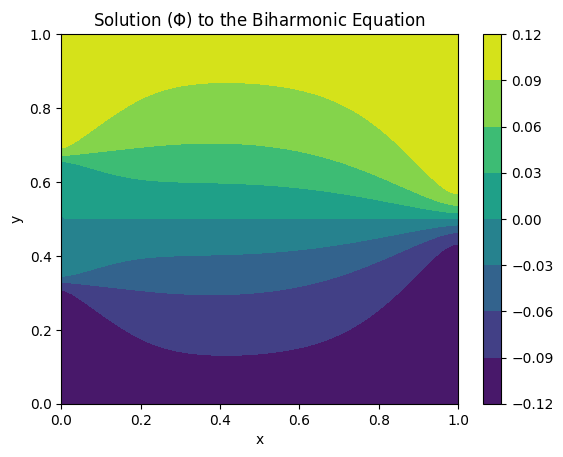

In [76]:
# Plot the solution
import matplotlib.pyplot as plt

X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, phi, cmap='viridis')
plt.colorbar()
plt.title('Solution ($\Phi$) to the Biharmonic Equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


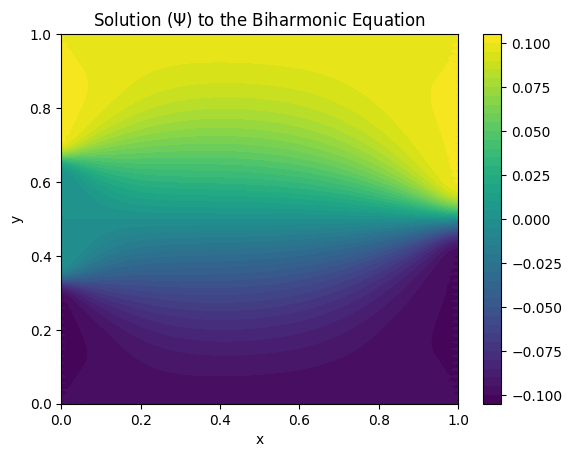

In [77]:
# Level plot with 50 levels
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, phi, levels=50, cmap='viridis')  # Increase to 50 levels
plt.colorbar()
plt.title('Solution ($\Psi$) to the Biharmonic Equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


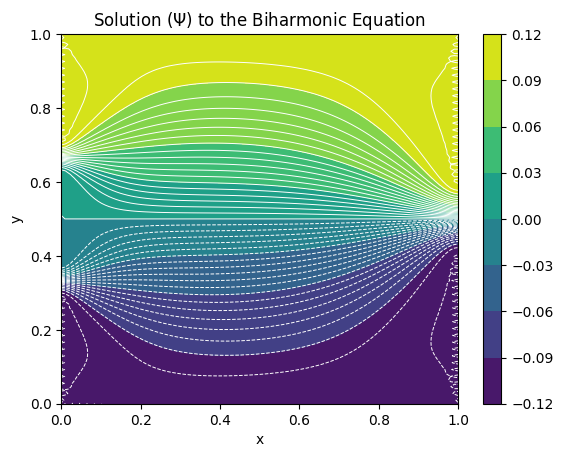

In [78]:
# Contour plot with white contour lines
X, Y = np.meshgrid(x, y)

plt.contourf(X, Y, phi, cmap='viridis')  # Filled contour plot
plt.colorbar()  # Color bar for reference

# Add contour lines over the filled contour plot
plt.contour(X, Y, phi, colors='w', levels=50, linewidths=0.7)  # Example: red color lines with width of 2

plt.title('Solution ($\Psi$) to the Biharmonic Equation')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [79]:
# phi

In [80]:
# Initialize gradient arrays
grad_x = np.zeros_like(phi)
grad_y = np.zeros_like(phi)

# Compute gradient with respect to x using central difference for interior points
grad_x[:, 1:-1] = (phi[:, 2:] - phi[:, :-2]) / (2 * dx)

# Second-order forward difference for left boundary
# grad_x[:, 0] = (-3*phi[:, 0] + 4*phi[:, 1] - phi[:, 2]) / (2 * dx)

# Second-order backward difference for right boundary
# grad_x[:, -1] = (3*phi[:, -1] - 4*phi[:, -2] + phi[:, -3]) / (2 * dx)

# Compute gradient with respect to y using central difference for interior points
grad_y[1:-1, :] = (phi[2:, :] - phi[:-2, :]) / (2 * dy)

# Second-order forward difference for bottom boundary
# grad_y[0, :] = (-3*phi[0, :] + 4*phi[1, :] - phi[2, :]) / (2 * dy)

# Second-order backward difference for top boundary
# grad_y[-1, :] = (3*phi[-1, :] - 4*phi[-2, :] + phi[-3, :]) / (2 * dy)

# By boundary conditions, the gradient at the boundaries is zero
grad_x[:, 0] = 0
grad_x[:, -1] = 0
grad_y[0, :] = 0
grad_y[-1, :] = 0

# grad_x and grad_y now contain the gradients with respect to x and y at each point, respectively, with improved accuracy at the boundaries.

In [81]:
# Calculate the velocity components
u_x = grad_y
u_y = -grad_x

# Calculate the velocity magnitude
velocity_magnitude = np.sqrt(u_x**2 + u_y**2)


In [82]:
# # print maximum velocity magnitude
# print(np.max(u_x))
# print(np.max(velocity_magnitude))

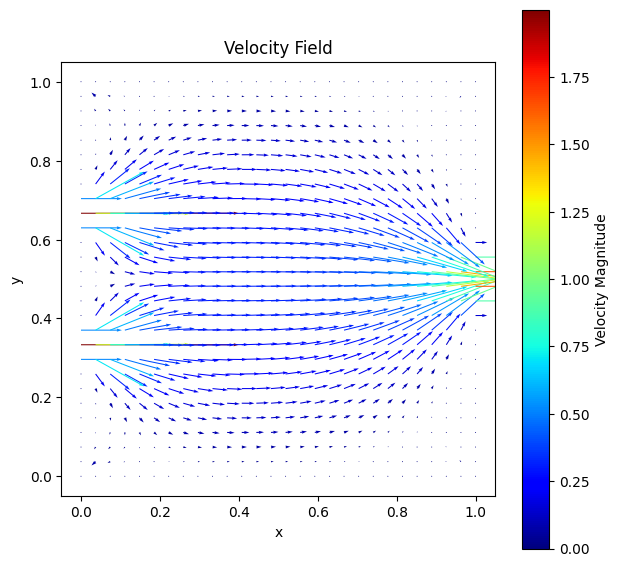

In [103]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Scale u_x and u_y for better visualization
u_x_scale = u_x * 0.02
u_y_scale = u_y * 0.02

# Calculate the velocity magnitude
velocity_magnitude_scale = np.sqrt(u_x_scale**2 + u_y_scale**2) * 50

# Create a meshgrid for plotting
X, Y = np.meshgrid(x, y)

# Select a step size for slicing; higher numbers will have fewer vectors
step = 4  # Adjust this to change the density of the vectors

# Slice the arrays to reduce the number of vectors
Y_slice = Y[::step, ::step]
X_slice = X[::step, ::step]
u_x_slice = u_x_scale[::step, ::step]
u_y_slice = u_y_scale[::step, ::step]
velocity_magnitude_slice = velocity_magnitude_scale[::step, ::step]

# Plot the velocity field
fig, ax = plt.subplots()
fig.set_size_inches(7, 7) # Adjust figure size

quiver = ax.quiver(X_slice, Y_slice, u_x_slice,  u_y_slice, velocity_magnitude_slice,
                   angles='xy', scale_units='xy', scale=0.1, cmap=cm.jet)
ax.set_aspect('equal')
ax.set_title('Velocity Field')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Adding a colorbar to represent the velocity magnitude
cbar = fig.colorbar(quiver, ax=ax)
cbar.set_label('Velocity Magnitude')

plt.show()



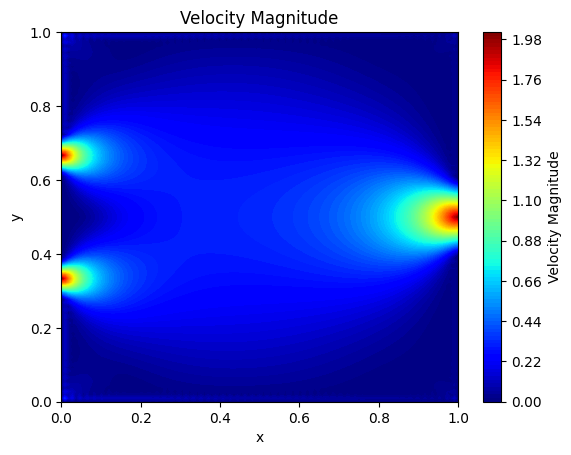

In [84]:
# Plot contours of the velocity magnitude
# adjust the figure size
fig, ax = plt.subplots()

# Create the contour plot
contourf = plt.contourf(X, Y, velocity_magnitude, cmap=cm.jet, levels=100)

# Create the colorbar with automatic scaling
cbar = plt.colorbar(contourf)
cbar.set_label('Velocity Magnitude')

plt.title('Velocity Magnitude')
plt.xlabel('x')
plt.ylabel('y')
plt.show()




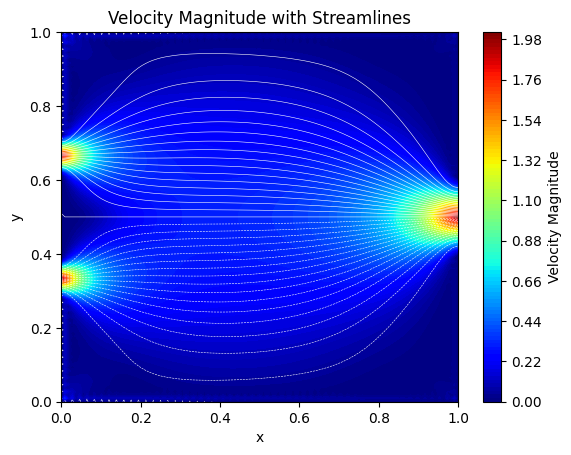

In [105]:
# Plot contours of the velocity magnitude from the second plot
fig, ax = plt.subplots()

# Create the filled contour plot
contourf = ax.contourf(X, Y, velocity_magnitude, cmap='jet', levels=100)

# Add contour lines from the first plot (white lines)
contour = ax.contour(X, Y, phi, colors='w', levels=35, linewidths=0.4)

# Create the colorbar with automatic scaling
cbar = plt.colorbar(contourf)
cbar.set_label('Velocity Magnitude')

plt.title('Velocity Magnitude with Streamlines')
plt.xlabel('x')
plt.ylabel('y')


# Show the plot as well
plt.show()



# Pressure Difference Across the Chamber (between inlet and outlet)

The pressure difference between the inlet (x = 0, y = 1/3) and outlet (x = 1, y = 1/2) across the chamber is given by the formula:
\begin{equation}
\Delta P_x = - \int \nabla P_x \ ds = - \int \nabla^2 U_x \ ds = - \int \left( \frac{\partial^2 U_x}{\partial x^2} + \frac{\partial^2 U_x}{\partial y^2} \right) \ ds, \\
\Delta P_y = - \int \nabla P_y \ ds = - \int \nabla^2 U_y \ ds = - \int \left( \frac{\partial^2 U_y}{\partial x^2} + \frac{\partial^2 U_y}{\partial y^2} \right) \ ds,
\end{equation}
where $dx$ is an infinitesimal element along the path. The pressure difference is calculated by integrating the Laplacian of the velocity field $U_x$ along the path from the inlet to the outlet.

In [86]:
# def calculate_pressure_difference(u_x, u_y, N, dx, dy):
#     # Assuming grid spacing is uniform and the domain is from 0 to 1
# 
#     # Approximate pressure gradients (assuming constant density rho)
#     pressure_gradient_x = np.gradient(u_x, axis=1) / dx
#     pressure_gradient_y = np.gradient(u_y, axis=0) / dy
# 
#     # Integrate pressure gradients along the path
#     # Vertical segment
#     delta_P_vertical = -np.sum(pressure_gradient_y[int(1/3*N) : int(1/2*N), 0]) * dy
#     # Horizontal segment
#     delta_P_horizontal = -np.sum(pressure_gradient_x[int(1/2*N), :]) * dx
# 
#     # Sum both contributions
#     delta_P = delta_P_vertical + delta_P_horizontal
# 
#     return delta_P
# 
# # Calculate the pressure difference across the chamber between the inlet and outlet (x = 0, y = 1/3 and x = 1, y = 1/2)
# delta_P = calculate_pressure_difference(u_x, u_y, Nx, dx, dy)
# print(f'Pressure difference across the chamber: {delta_P}')

In [87]:
# x_start = 0
# x_end = 1*Nx
# y_start = int(1/3*Ny)
# y_end = int(1/2*Ny)
# print(x_start, x_end, y_start, y_end)

In [88]:
# Calculate the pressure difference across the chamber between the inlet and outlet (x = 0, y = 1/3 and x = 1, y = 1/2)
j_start = int(1/3*Ny)
j_end = int(1/2*Ny)
delta_P_x = 0
delta_P_y = 0

# Calculate the pressure difference between the inlet and outlet
# i == 0: 
# 2nd order forward difference : 2u_x[0, j] - 5u_x[1, j] + 4u_x[2, j] - u_x[3, j]
delta_P_x += (2 * u_x[j_start, 0] - 5 * u_x[j_start, 1] + 4 * u_x[j_start, 2] - u_x[j_start, 3]) / (dx ** 2) + (u_x[j_start+1, 0] - 2 * u_x[j_start, 0] + u_x[j_start-1, 0]) / (dy ** 2)
delta_P_y += (2 * u_y[j_start, 0] - 5 * u_y[j_start, 1] + 4 * u_y[j_start, 2] - u_y[j_start, 3]) / (dx ** 2) + (u_y[j_start+1, 0] - 2 * u_y[j_start, 0] + u_y[j_start-1, 0]) / (dy ** 2)


# for i = 1 ... Nx-1 (leap 6 grid points of x for one grid point of y)
i = 0
for j in range(j_start+1, j_end):
    i += 6
    delta_P_x += (u_x[j, i+1] - 2 * u_x[j, i] + u_x[j, i-1]) / (dx ** 2) + (u_x[j+1, i] - 2 * u_x[j, i] + u_x[j-1, i]) / (dy ** 2)
    delta_P_y += (u_y[j, i+1] - 2 * u_y[j, i] + u_y[j, i-1]) / (dx ** 2) + (u_y[j+1, i] - 2 * u_y[j, i] + u_y[j-1, i]) / (dy ** 2)
        
# for i = Nx: 2nd order backward difference : 2u_x[Nx, j] - 5u_x[Nx-1, j] + 4u_x[Nx-2, j] - u_x[Nx-3, j]
delta_P_x += (2 * u_x[j_end, -1] - 5 * u_x[j_end, -2] + 4 * u_x[j_end, -3] - u_x[j_end, -4]) / (dx ** 2) + (u_x[j_end+1, -1] - 2 * u_x[j_end, -1] + u_x[j_end-1, -1]) / (dy ** 2)
delta_P_y += (2 * u_y[j_end, -1] - 5 * u_y[j_end, -2] + 4 * u_y[j_end, -3] - u_y[j_end, -4]) / (dx ** 2) + (u_y[j_end+1, -1] - 2 * u_y[j_end, -1] + u_y[j_end-1, -1]) / (dy ** 2)

# Calculate the pressure difference
delta_P = np.sqrt(delta_P_x ** 2 + delta_P_y ** 2)

print(f'Pressure difference across the chamber: {delta_P}')

    

Pressure difference across the chamber: 15284.369106585013


# Shear Stress on the Boundary

For $x = 0$ and $x=1$, the shear stress is given by 

\begin{equation}
\tau = \frac{\partial U_y}{\partial x}, 
\end{equation}

where $U_y = -\frac{\partial \Phi}{\partial x}$. Hence, we have

\begin{equation}
\tau = -\frac{\partial^2 \Phi}{\partial x^2}.
\end{equation} 

In [110]:
# Calculate the shear stress on the boundary
tau = np.zeros((Nx+1, Ny+1))
lamb = 2/10  # Width of the boundary region

# Calculate the shear stress at the boundary points using 2nd order 2nd derivative approximation forwards and backwards
for j in range(Ny+1):
    if 1/2 - lamb/2 > j*dy or j*dy > 1/2 + lamb/2:
        # x = 0:
        tau[j, 0] = -1 * (- phi[j, 3] + 4 * phi[j, 2] - 5 * phi[j, 1] + 2 * phi[j, 0]) / (dx ** 2)
        # x = 1:
        tau[j, -1] = -1 * (2 * phi[j, -1] - 5 * phi[j, -2] + 4 * phi[j, -3] - phi[j, -4]) / (dx ** 2)
        
for i in range(1, Nx):
    # y = 0:
    tau[0, i] = -1 * (- phi[3, i] + 4 * phi[2, i] - 5 * phi[1, i] + 2 * phi[0, i]) / (dy ** 2)
    # y = 1:
    tau[-1, i] = -1 * (2 * phi[-1, i] - 5 * phi[-2, i] + 4 * phi[-3, i] - phi[-4, i]) / (dy ** 2)


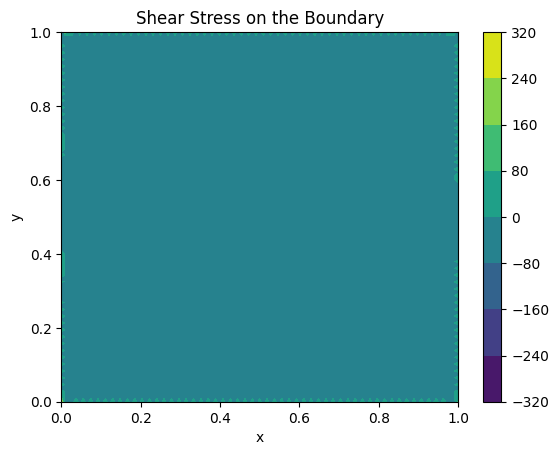

In [111]:
# Plot the shear stress
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, tau, cmap='viridis')
plt.colorbar()
plt.title('Shear Stress on the Boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [112]:
# print the shear stress at x = 0 and x = 1
print(tau[:, 0])
print(tau[:, -1])

[ 286.59284575  113.55944283    1.67252072   13.15209055  -20.81794072
   11.49706667  -18.67684631   13.58232113  -17.17631656   14.61295263
  -16.4581457    15.13039827  -16.07395461   15.42429299  -15.8452971
   15.60555577  -15.70147762   15.72028621  -15.61227068   15.78751102
  -15.56782511   15.80762657  -15.58049836   15.74669507  -15.72661924
   15.43731987  -16.37937545   14.0331165   -19.44462633    7.51643894
  -31.59565947   -4.60847009  -40.800285    -14.33215263  -39.2153053
    1.4230912    -7.60722589   14.73318979   23.99730532   30.48130451
   25.57150849   20.74309546   16.34846427    8.59568853    0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
    0.            0.            0.            0.            0.
   -8.59568905  -16.34846478  -20.74309596  -25.57150898  -30.48130498
  -23.99730578  -14.73319024    7.60722545   -1.

In [113]:
# # Calculate the shear stress on the boundary
# # The shear stress is given by the formula: tau = partial u_y / partial x
# 
# tau_1 = np.zeros((Nx+1, Ny+1))
# lamb = 2/10  # Width of the boundary region
# 
# # Calculate the shear stress at the boundary points using 2nd order forward/backward finite difference approximation
# for j in range(Ny+1):
#     if 1/2 - lamb/2 > j*dy or j*dy > 1/2 + lamb/2:
#         # x = 0: partial u_y / partial x = (-1/2* u_y[2, j] + 2 * u_y[1, j] -3/2* u_y[0, j]) / dx
#         tau_1[j, 0] = (-1/2 * u_y[j, 2] + 2 * u_y[j, 1] - 3/2 * u_y[j, 0]) / dx
#         # x = 1: partial u_y / partial x = (1/2* u_y[Nx-2, j] - 2 * u_y[Nx-1, j] +3/2* u_y[Nx, j]) / dx
#         tau_1[j, -1] = (1/2 * u_y[j, -3] - 2 * u_y[j, -2] + 3/2 * u_y[j, -1]) / dx
#         
# print(tau_1[:, 0])
# print(tau_1[:, -1])
# 
# # Plot the shear stress
# X, Y = np.meshgrid(x, y)
# plt.contourf(X, Y, tau_1, cmap='viridis')
# plt.colorbar()
# plt.title('Shear Stress on the Boundary')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.show()

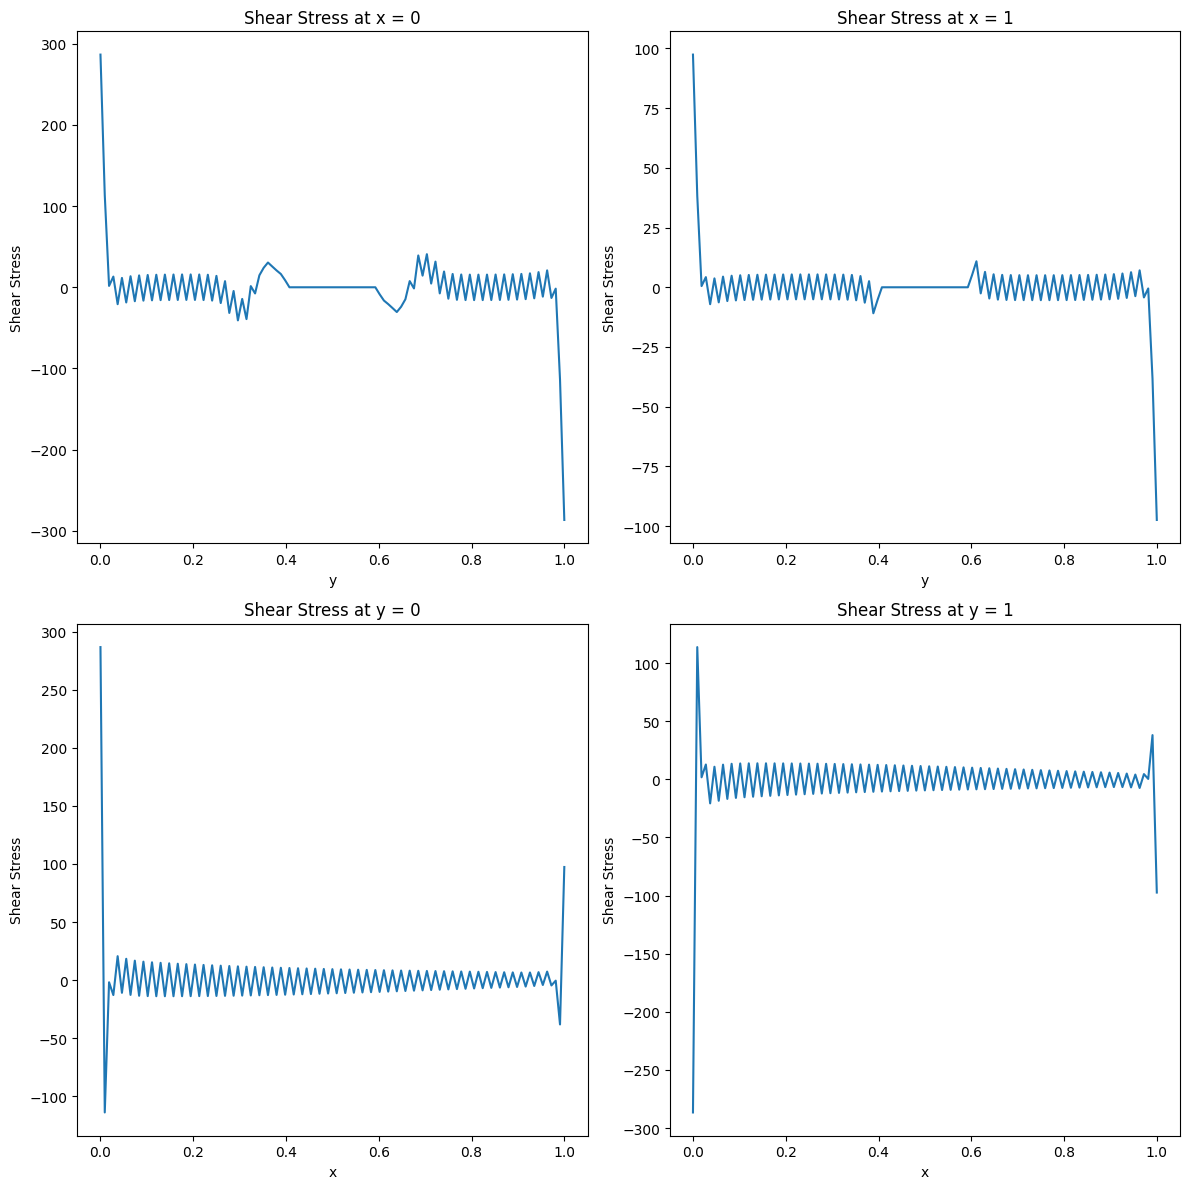

In [114]:
# Draw four line plots of the shear stress at four boundaries x = 0, x = 1, y = 0, y = 1
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

# x = 0
ax[0, 0].plot(y, tau[:, 0])
ax[0, 0].set_title('Shear Stress at x = 0')
ax[0, 0].set_xlabel('y')
ax[0, 0].set_ylabel('Shear Stress')

# x = 1
ax[0, 1].plot(y, tau[:, -1])
ax[0, 1].set_title('Shear Stress at x = 1')
ax[0, 1].set_xlabel('y')
ax[0, 1].set_ylabel('Shear Stress')

# y = 0
ax[1, 0].plot(x, tau[0, :])
ax[1, 0].set_title('Shear Stress at y = 0')
ax[1, 0].set_xlabel('x')
ax[1, 0].set_ylabel('Shear Stress')

# y = 1
ax[1, 1].plot(x, tau[-1, :])
ax[1, 1].set_title('Shear Stress at y = 1')
ax[1, 1].set_xlabel('x')
ax[1, 1].set_ylabel('Shear Stress')

plt.tight_layout()

plt.show()


## Realistic Test Case

1. Change the boundary condition on the outlet to be constant velocity $U$ instead of the parabolic profile (mind that it should generate the same flow as the inlet, so $U*\lambda=Q$, where $\lambda$ is the width of the outlet and $Q = \lambda ^2$ is the flow rate at the inlet).


2. try different positioning and size of the outlet, and maybe add more inlets/outlets.